In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

__Читаем данные__

In [2]:
# прочитали train набор 
data_train = pd.read_csv("train.csv")
data_train.head()

,Id,Data,Target
0,2,1196196 6649 631757 352482 129763 1488867 4196...,3 4 5 57562 143308 602645
1,8,160601,21 666511
2,9,4036 184532 253735 164416 2711233,22 23 24 859 273402
3,30,364007 585243 1053 96977 757925 262078 277037 ...,69 70 71 72 25723 29894 77836 89724 101092 142...
4,34,454100 468340 170827 1156224,83 31304 126449


In [3]:
# прочитали test набор 
data_test = pd.read_csv("test.csv")
data_test.head()

,Id,Data
0,1,1488866 5821 1632 124514
1,3,2935816
2,25,63 56990 10217 35352 364303 364303 1060991 209...
3,28,34769
4,32,2239802 756075 1901311 2239803 2239804 1451281...


In [4]:
# прочитали submission
submission = pd.read_csv("submission.csv")
submission.head()

,Id,Predicted
0,1,2674 2607 3125 4232 859 5141 4254 6845 1443 558
1,3,2674 2607 3125 4232 859 5141 4254 6845 1443 558
2,25,2674 2607 3125 4232 859 5141 4254 6845 1443 558
3,28,2674 2607 3125 4232 859 5141 4254 6845 1443 558
4,32,2674 2607 3125 4232 859 5141 4254 6845 1443 558


Посмотрим, можно ли что то извлечь из Id.

In [5]:
len(data_train['Id'].unique())

200000

Ой, это не пользователи а видимо просто id событий. Ничего не извлечь из этого.

Создадим датафрейм, содержащий все существующие пересечения вида<br>
**Товар из Data** - **Товар из Target**

In [6]:
data_lst = []
target_lst = []

for _, row in tqdm(data_train.iterrows(), total=data_train.shape[0]):
    data_lst.append(list(row["Data"].split()))
    target_lst.append(list(row["Target"].split()))
    
data_train["Data"] = data_lst
data_train["Target"] = target_lst

  0%|          | 0/200000 [00:00<?, ?it/s]

In [7]:
data_train.head()

,Id,Data,Target
0,2,"[1196196, 6649, 631757, 352482, 129763, 148886...","[3, 4, 5, 57562, 143308, 602645]"
1,8,[160601],"[21, 666511]"
2,9,"[4036, 184532, 253735, 164416, 2711233]","[22, 23, 24, 859, 273402]"
3,30,"[364007, 585243, 1053, 96977, 757925, 262078, ...","[69, 70, 71, 72, 25723, 29894, 77836, 89724, 1..."
4,34,"[454100, 468340, 170827, 1156224]","[83, 31304, 126449]"


In [8]:
# матрица всех пересечений Data и Target
intersect_df = data_train.explode("Data").explode("Target")
intersect_df["Data"] = intersect_df["Data"].astype(int)
intersect_df["Target"] = intersect_df["Target"].astype(int)
intersect_df.head()

,Id,Data,Target
0,2,1196196,3
0,2,1196196,4
0,2,1196196,5
0,2,1196196,57562
0,2,1196196,143308


In [9]:
intersect_df.shape[0]

8934889

__Найдем ТОР-10 самых популярных товаров в Target__, будем считать их 'ответом' на отсутствие ответа.

In [10]:
# Подсчет количества повторений элементов в последовательности target
cnt_target = Counter(intersect_df["Target"])
len(cnt_target)

528563

In [11]:
# 10 самых частых (во 2 столбце количество встреч) по убыванию
cnt_target.most_common(10)

[(3125, 2125),
 (2607, 2108),
 (859, 2003),
 (1443, 1834),
 (6523, 1747),
 (11446, 1593),
 (5306, 1559),
 (4254, 1446),
 (4232, 1420),
 (7144, 1357)]

In [12]:
# это наши 10 самых встречаемых товаров в Target, base_rec - готовая запись
rec_ids = list(map(lambda x: x[0], cnt_target.most_common(10)))
base_rec = " ".join([str(id) for id in rec_ids])
base_rec_int=rec_ids
base_rec

'3125 2607 859 1443 6523 11446 5306 4254 4232 7144'

Создадим датафрейм, содержащий количество пересечений для каждой из пар<br>
**Товар из Data** - **Товар из Target**

In [53]:
count_df = intersect_df.groupby(["Data", "Target"], as_index=False).count().rename(columns={'Id': 'count'})
count_df.head()

,Data,Target,count
0,1,10119,1
1,1,65333,1
2,1,128791,1
3,1,155117,1
4,1,210215,1


In [47]:
count_df.shape[0]

7753830

In [54]:
# было так: count_df.sort_values(by=["Target", "count"], ascending=[True, False], inplace=True)
count_df.sort_values(by=["Target", "count"], ascending=[True, False], inplace=True)


In [49]:
# пример записи для Data=8377
count_df[count_df['Data']==8377]

,Data,Target,count
305873,8377,39,5
305874,8377,14284,5
305875,8377,28678,1
305876,8377,38125,1
305877,8377,56846,5
305878,8377,387936,1
305879,8377,776764,1


In [55]:
# отсортируем 
count_df.sort_values(by=["Data", "count"], ascending=[True, False], inplace=True)
# пример записи для Data=8377
count_df[count_df['Data']==8377]

,Data,Target,count
305873,8377,39,5
305874,8377,14284,5
305877,8377,56846,5
305875,8377,28678,1
305876,8377,38125,1
305878,8377,387936,1
305879,8377,776764,1


Создадим dataframe в котором будут Target с количством повторений (count), заджойним его с датафреймом пересечений count_df

In [56]:
# создадим dataframe в котором каждому значению Target будет соответствовать количество повторений в data_train
count_target=intersect_df.groupby(["Target"], as_index=False).count().rename(columns={'Id': 'count'})
count_target=count_target.drop(['Data'], axis=1)
count_target.head()

,Target,count
0,2,56
1,3,58
2,4,38
3,5,40
4,11,77


In [57]:
# заJOINим полученый dataframe с count_df
count_df=count_df.merge(count_target, left_on='Target', right_on='Target')
count_df.rename(columns={'count_x':'Count_DT', 'count_y':'Count_T'}, inplace=True)
count_df.head()

,Data,Target,CountDT,Count_T
0,1,10119,1,493
1,232,10119,1,493
2,619,10119,1,493
3,890,10119,2,493
4,1004,10119,3,493


В нашем итоговом dataframe отсортируемся по убыванию Count_DT и Count_T и оставим только первые/верхние 10 значений (которые потенциально могут попасть в рекомендации), таким образом сократим размер нашего датафрейма и объем последующих вычислений.

In [96]:
# Режем count_df, по каждому объекту Data, оставляем только топ10 пересечений с Target
products_ids=count_df['Data'].unique()
new_count_df=pd.DataFrame()
for i in tqdm(range(len(products_ids))):
    new_count_df=new_count_df.append(count_df[count_df['Data']==products_ids[i]].sort_values(['Data', 'Count_DT', 'Count_T'], ascending=False)[0:10])
new_count_df.to_csv("new_count_df_only10.csv", index=False)
# запишем результат в файл и в последующих экспериментах будем им пользоваться

  0%|          | 0/543743 [00:00<?, ?it/s]

In [137]:
new_count_df = pd.read_csv("new_count_df_only10.csv")
print('Размер до оптимизации: ',count_df.shape[0])
print('Размер после оптимизации: ',new_count_df.shape[0])

Размер до оптимизации:  7753830
Размер после оптимизации:  3493529


In [95]:
i=1
products_ids=count_df['Data'].unique()
new_count_df=pd.DataFrame()
count_df[count_df['Data']==products_ids[i]].sort_values(['Data', 'CountDT', 'Count_T'], ascending=False)[0:10]

,Data,Target,CountDT,Count_T
309370,232,19911,2,461
309770,232,131606,2,181
310373,232,414008,2,170
311227,232,1777380,2,165
309935,232,156218,2,163
310224,232,252820,2,162
310663,232,566957,2,157
311085,232,1063325,2,156
310085,232,239288,2,152
310524,232,524393,2,152


Следующее решение было самым последним в цепочке экспериментов и дало самый высокий score. В нем, в том числе, все единичные пересечения земняются на самые вероятные из base_rec, в каждой рекмомендации выдается именно 10 позиций, а не меньше, отбор рекомендаций для выдачи происходит по отбору самых весомых по пересекаемости и повторению в учебном датафрейме. 

In [135]:
# опишем функцию
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=new_count_df[new_count_df["Data"].isin(products)].sort_values(by=['CountDT', 'Count_T'], ascending=False)[0:10]
    k=k[k['CountDT']!=1]
    recs_ids=(k['Target'].values.tolist()+base_rec_int)[0:10]
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec

In [136]:
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))
    
# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv("SorokaD_14.02.22_topTarget_sort.csv", index=False)

  0%|          | 0/200000 [00:00<?, ?it/s]

__Ниже приведена цепочка/последовательность рассуждений в процессе работы над задачей.__

__Если использовать id товаров в качестве индексов, размер матрицы будет очень большим. Перейдем от id к номеру товара.__

In [18]:
# список всех продуктов и data и target
all_products = set(count_df["Data"].unique().tolist() + count_df["Target"].unique().tolist())
len(all_products)

872533

In [19]:
# Пронумерованный Словарь номер товара -> id товара 
num_to_id = dict(enumerate(all_products))
# Пронумерованный Словарь id товара -> номер товара
id_to_num = dict(zip(num_to_id.values(), num_to_id.keys()))
len(id_to_num)

872533

__Сделаем матрицу пересечений, по строкам значения из Data, в столбцах значения из Target, в ячейках сумма/количество пересечений__

In [20]:
count_matrix = csr_matrix((count_df["count"].values,
              (count_df["Data"].map(id_to_num).values, count_df["Target"].map(id_to_num).values)))
# для примера: элементы таблицы где пересечений >=50
count_df[count_df["count"] >= 50]


,Data,Target,count
4871245,640044,9492,50
4871247,640044,28279,50
4871249,640044,39272,50
4871256,640044,94187,50
4871257,640044,116917,50
4871269,640044,371505,50
4871272,640044,520499,50
4871273,640044,623460,50
4871275,640044,754773,50


In [21]:
# в ячейке матрице скоординатами '640044'x'9492' лежит количество пересечений этих двух товаров
count_matrix[id_to_num[640044], id_to_num[9492]]

50

In [ ]:
# перевод разряженной матрицы в DataFrame. ACHTUNG !!! очень долго !!!
# sdf = pd.DataFrame.sparse.from_spmatrix(count_matrix)
# sdf.head()

In [ ]:
# попытка создать матрицу все-data-товары на 10 самых тяжелых рекомендаций 
# очень долго, расчетное время 12 часов
#recs_lst=[]
#for i in tqdm(range(len(count_df["Data"].unique().tolist()))):
#    sum_matrix = np.sum(count_matrix[id_to_num[1], :], axis=0)
#    recs_num = np.argsort(-sum_matrix).tolist()[0][:10]
#    recs_ids = [num_to_id[num] for num in recs_num]
#    recs_lst.append(recs_ids)

__Работа с марицей пересечений очень затратна по времени__ ... всякая попытка поработать с матрицей упирается либо недостаток ресурса либо в "бесконечное" время 12+ часов.

<ipython-input-22-5ce32061055c>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


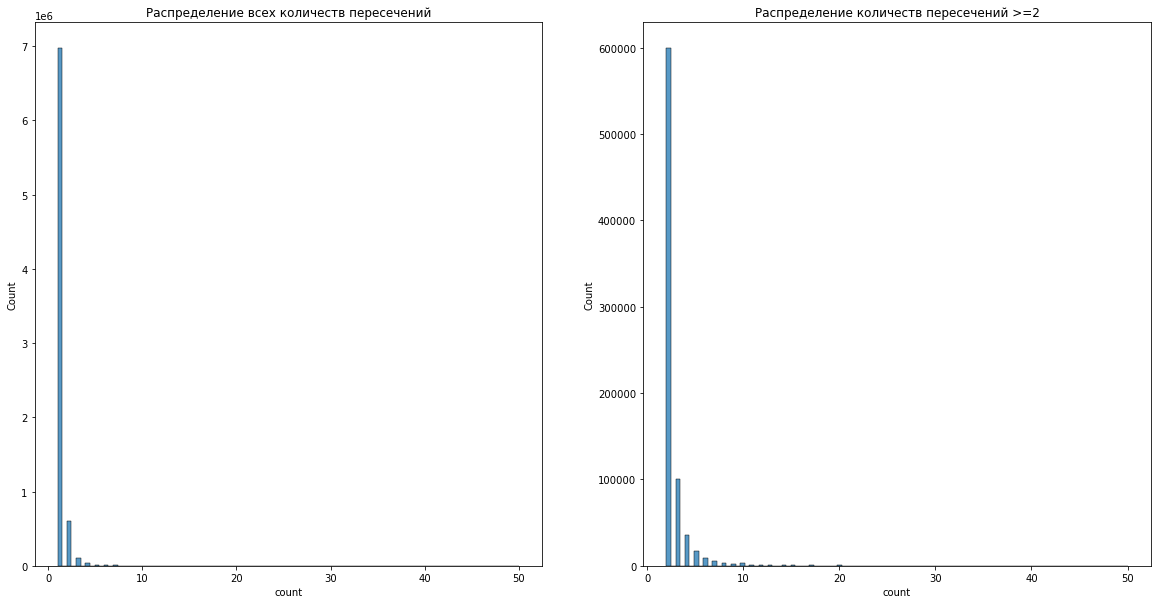

In [22]:
# Посмотрим на распределение количеств пересечений
fig, ax =plt.subplots(1,2,figsize=(20,10))
sns.histplot(count_df.query('count>=1')['count'], ax=ax[0],bins=100)
ax[0].set_title('Распределение всех количеств пересечений')
sns.histplot(count_df.query('count>=2')['count'], ax=ax[1],bins=100)
ax[1].set_title('Распределение количеств пересечений >=2')
fig.show()


In [23]:
print('Пар у которых количество пересечений =1 :', count_df.query('count==1').shape[0])
print('Пар у которых количество пересечений >=2 :', count_df.query('count>=2').shape[0])

Пар у которых количество пересечений =1 : 6974595
Пар у которых количество пересечений >=2 : 779235


Наблюдаем, что 'единичных' пересечений 90%. 

__Логика отбора рекомендаций для Data__ (оставил 'разжеваным' для себя, что бы, быть может потом, легче было вспомнить).

In [24]:
# единичный пример отбора рекомендаций для data=160
k=count_df.query('Data==160')
k=k.sort_values(by=["count"], ascending=False)[0:10]
rec_ids=k['Target']
rec_ids=rec_ids.values.tolist()
rec_ids

[2779, 85529, 541945, 29604, 160, 859, 72567, 1038377, 357444, 2788943]

In [25]:

# единичный пример отбора рекомендаций для Data= 160, 1196196
k=count_df[count_df["Data"].isin([160, 1196196])]
# сортируем их по убыванию count, отбираем 10 верхних
k=k.sort_values(by=["count"], ascending=False)[0:10]
# формируем запись в Target test-набора
rec_ids=k['Target']
rec_ids=rec_ids.values.tolist()
rec_ids
# 'всплывают' только самые 'тяжелые' рекомендации по обоим/всем значениям Data

[2779, 85529, 541945, 29604, 160, 859, 72567, 1038377, 357444, 2788943]

In [26]:
# в переменную j кладем 5 строку столбца data массива test 
j=data_test['Data'].loc[5]
# переводим строку в int список 
products = [int(prod) for prod in j.split()]
k=count_df[count_df["Data"].isin(products)]
# сортируем их по убыванию count, отбираем 10 верхних
k=k.sort_values(by=["count"], ascending=False)[0:10]
# формируем запись в Target test-набора
rec_ids=k['Target']
rec_ids=rec_ids.values.tolist()
rec_ids

[59161,
 591989,
 235922,
 2687879,
 2610350,
 1036463,
 1032225,
 1029503,
 951960,
 926660]

In [27]:
# Собираем все в кучу и Описываем функцию
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=count_df[count_df["Data"].isin(products)]
    k=k.sort_values(by=["count"], ascending=False)[0:10]
    recs_ids=k['Target'].values.tolist()
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec
# обращаем внимание на то, что возможно ситуация когда функция вернет <10 рекомендаций

In [28]:
# посмотрим на результат на примере 5 строки
print(target_gen(data_test['Data'].loc[5]))

59161 591989 235922 2687879 2610350 1036463 1032225 1029503 951960 926660


псевдоФИНАЛЬНЫЙ РАСЧЕТ ЗНАЧЕНИЙ TARGET (на этом этапе 'всплыли' небольшие ошибки, которые были исправлены).

In [ ]:
# запуск функции по всему data_test
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))
    
# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv(PATH + "SorokaD_bl3.csv", index=False)

__Попробуем сократить время расчетов и создаим new_count_df, каждму пересечению Data и Target оставим только топ10 самых частых пересечений__ (это первый вариант усеченного count_df с одним столбцом count,  время выполнения 9 часов, не уверен что это было нужно... по моему всетаки финальные расчеты что так, что так занимают 2-3 часа, а нет .... с неурезанным count_df 8-9 часов, значит нужно)

In [ ]:
# Режем count_df, по каждому объекту Data, оставляем только топ10 пересечений с Target
products_ids=count_df['Data'].unique()
new_count_df=pd.DataFrame()
for i in tqdm(range(len(products_ids))):
    new_count_df=new_count_df.append(count_df[count_df['Data']==products_ids[i]].head(10))
new_count_df.to_csv("new_count_df_only10.csv", index=False)
# запишем результат в файл и в последующих экспериментах будем им пользоваться

In [29]:
new_count_df = pd.read_csv("new_count_df_only10.csv")
print('Размер до оптимизации: ',count_df.shape[0])
print('Размер после оптимизации: ',new_count_df.shape[0])

Размер до оптимизации:  7753830
Размер после оптимизации:  3493529


По логике работы алгоритма мы всем товарам из строки Data (data_test) отбираем 10 наиболее часто продаваемых товаров из Target (data_train) за предыдущий/известный период и таким образом строим рекомендацию. Если в data_test встречается товар по которому нет истории в data_train мы, на удачу, рекомендуем топ10 самых продаваемых товаров из Target в истории data_train. 

__Попробуем в отдельную задачу выделить случай, когда за историю data_train пересечения товаров случались только 1 раз__. Можем ли мы считать единичное пересечение Data и Target поводом для рекомендации !?!?!? 

In [30]:
print('Пар у которых количество пересечений =1 :', count_df.query('count==1').shape[0])
print('Пар у которых количество пересечений =2+ :', count_df.query('count>=2').shape[0])

Пар у которых количество пересечений =1 : 6974595
Пар у которых количество пересечений =2+ : 779235


In [31]:
# наши рекомендации на случай 'отсутсвия данных'
base_rec

'3125 2607 859 1443 6523 11446 5306 4254 4232 7144'

In [32]:
# Список наиболее частых Target среди единичных пересечений
temp_df=count_df.query('count==1')
cnt_target = Counter(temp_df["Target"])
rec_ids = list(map(lambda x: x[0], cnt_target.most_common(10)))
base_rec1 = " ".join([str(id) for id in rec_ids])
base_rec1_int=rec_ids
base_rec1

'3125 2607 859 1443 11446 6523 5306 4254 7144 558'

Практически нет разницы в 'общих ' и 'единичных' топ10 (разница в одну позицию + есть 'ранговые' различия).

Попытка объявить единичные пересечения абсолютно случайными и упразнить их (полностью от них отказаться) привела к заметному снижению качества работы алгоритма.

Я бы попорбовал заменить 'едниничные' рекомендации на топ10, который вычислил выше, если будет время - попробую и сравню результат (эта идея привела к увеличеиню score).

Кроме того, мы наблюдаем, что возможна ситуация когда наш алгоритм 'недорекомендует'..., в то время как в рекомендации может быть 10 товаров, алгоритм выдает меньше. 

In [33]:
# посмотрим на пример с Data=801643
new_count_df.query('Data==801643')

,Data,Target,count
2031856,801643,86,3


In [34]:
print('Рекомендация нашего алгоритма для Data=801643: ', target_gen('801643'))

Рекомендация нашего алгоритма для Data=801643:  86


__1 рекомендация - это непристойно мало__, в то время когда мы имеем возможность дать 10. Изменим функцию target_gen... Много думал как лучше поступить, делать ли if каждой полученной строки и по результатам добавлять необходимое или 'по умолчанию' приплюсовывать к каждой результирующей строке base_rec срезая полученное до 10 значений..., вопрос борьбы за время!!! не обладая достоверными знаниями на предмето того, что же будет работать быстрее, предположу, что второй вариант интереснее. 

In [35]:
# дополненная функция 
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=new_count_df[new_count_df["Data"].isin(products)].sort_values(by=["count"], ascending=False)[0:10]
    recs_ids=(k['Target'].values.tolist()+base_rec_int)[0:10]
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec

In [36]:
# проверим как работает
print('Рекомендация нашего алгоритма с учетом модификации: ', target_gen('801643'))

Рекомендация нашего алгоритма с учетом модификации:  86 3125 2607 859 1443 6523 11446 5306 4254 4232


Я бы еще предположил что есть/могут быть какие-то парные связи, типа: сегодня купив ботинки и брюки, завтра человек приходит за носками... если такие парные связи есть, то можно пробовать улучшить качество/плотность рекомендации. Не уверен, что поспею к сроку с реализацией этой идеи....

In [154]:
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))

# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv("SorokaD_bl3_plus.csv", index=False)

  0%|          | 0/200000 [00:00<?, ?it/s]

Попробуем предположить абсолютную случайность единичных пересечений и в рекомендациях заменим все единичные пересечения на значения из base_rec(_1) (топ10 среди 'единичных' пересечений)

In [37]:
# дополненная функция, там где попадаются единицы рекомендуем base_rec1
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=new_count_df[new_count_df["Data"].isin(products)].sort_values(by=["count"], ascending=False)[0:10]
    if k['count'].count()<=10: return base_rec1 # ошибка !!! все рекомендации, количеством <=10 обращаются в base_rec1 
    recs_ids=(k['Target'].values.tolist()+base_rec_int)[0:10]
    print(recs_ids)
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec

In [61]:
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))

# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv("SorokaD_bl3_plus_1.csv", index=False)


  0%|          | 0/200000 [00:00<?, ?it/s]

__Идея оказалась плохой, результат score=0.0010!!!__ Хотя это очень странно..., полез разбираться, нашел ошибку, переписываем функцию и делаем еще раз.

Функция добивания единичных пересечений самыми популярными рекомендациями из 'единичных' (привело к ухудшению score)

In [38]:
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=new_count_df[new_count_df["Data"].isin(products)].sort_values(by=["count"], ascending=False)[0:10]
    k=k[k['count']!=1]
    recs_ids=(k['Target'].values.tolist()+base_rec1_int)[0:10]
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec

In [55]:
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))
    
# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv("SorokaD_11.02.22_19.33.csv", index=False)

  0%|          | 0/200000 [00:00<?, ?it/s]

Функция добивания единичных+2 пересечений самыми популярными рекомендациями (результат ухудшился, отметаем эту идею)

In [39]:
def target_gen(data_str):
    products = [int(prod) for prod in data_str.split()]
    k=new_count_df[new_count_df["Data"].isin(products)].sort_values(by=["count"], ascending=False)[0:10]
    k=k[k['count']>2]
    recs_ids=(k['Target'].values.tolist()+base_rec_int)[0:10]
    return " ".join([str(prod) for prod in recs_ids]) if len(recs_ids) else base_rec

In [98]:
recs_lst = []
for _, row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    recs_lst.append(target_gen(row["Data"]))
# запись результата в файл
submission["Predicted"] = recs_lst
submission.to_csv("SorokaD_11.02.22_23.03.csv", index=False)

  0%|          | 0/200000 [00:00<?, ?it/s]

__Главные компоненты.__ Все-таки было бы любопытно поработать с count_matrix, так например выбирать пример(ы) для подражания опираясь на похожесть объектов Data(например когда у нас еть 10+ объектов с равным/соизмеримым количеством пересечений) используя косинусное расстояние между ними.

Попробуем уменьшить размерность count_matrix методом главных компонент.

In [111]:
from sklearn.decomposition import TruncatedSVD
# svd
svd = TruncatedSVD(n_components=5)
svd.fit(count_matrix)
result = svd.transform(count_matrix)
# результат строки ниже позволяет оценить насколько хорошо n_components=5 будет отображать изменчивость наших данных
svd.explained_variance_ratio_.sum()

0.04860660478466556

In [110]:
# попробуем оценить качество svd при n_components=200
svd = TruncatedSVD(n_components=200)
svd.fit(count_matrix)
result = svd.transform(count_matrix)
# print(result)
svd.explained_variance_ratio_.sum()

0.25915761336649334

25.9% мало (желаемое - 80-90%), пока ячейка отрабатывалась, ноутбук утратил признаки жизни, ушел в глубокую медитаию, но результат все-таки выдал. Попытку отыскать приемлимый n_components, в условиях моего железа, считаю не целесообразной.